In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Try to preview the images

color_image = cv.imread('../data/small_box/color_image.png')
depth_image = cv.imread('../data/small_box/raw_depth.png')
depth_display = cv.normalize(depth_image, None, 0, 255, cv.NORM_MINMAX)
depth_display = depth_display.astype(np.uint8)
print("depth: ", depth_image.shape)
print("RGB", color_image.shape)

depth:  (480, 640, 3)
RGB (480, 640, 3)


In [14]:
import open3d as o3d

# Load .ply file
ply_file_path = "../data/small_box/small_box_10_raw.ply"
pcd = o3d.io.read_point_cloud(ply_file_path)

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd])


[Open3D WARNING] GLFW Error: X11: Failed to open display 1
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


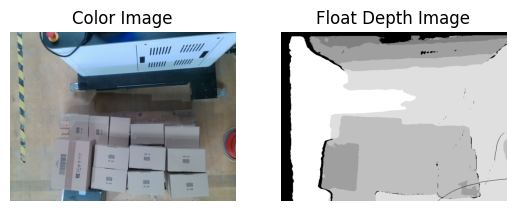

In [15]:
plt.subplot(121)
plt.imshow(cv.cvtColor(color_image, cv.COLOR_BGR2RGB))
plt.title('Color Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(depth_display,'plasma')
plt.title('Float Depth Image')
plt.axis('off')
plt.show()



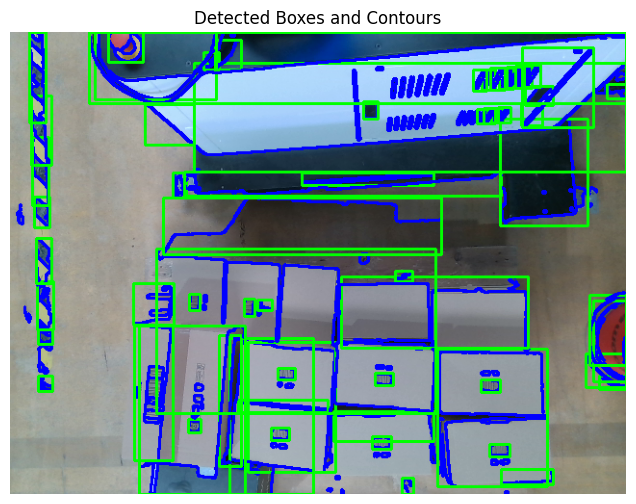

In [8]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('../data/small_box/color_image.png')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Perform Canny Edge Detection with adjusted thresholds
edges = cv2.Canny(blurred, 30, 100)  # Adjust thresholds for better edge detection

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours and bounding boxes
image_with_contours = image.copy()
for contour in contours:
    # Draw the contour on the image
    cv2.drawContours(image_with_contours, [contour], -1, (255, 0, 0), 2)  # Blue contours

    # Get bounding box and filter small boxes
    x, y, w, h = cv2.boundingRect(contour)
    if w > 10 and h > 10:  # Adjust size filter for smaller boxes
        cv2.rectangle(image_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Green bounding box

# Convert BGR image to RGB for matplotlib
image_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

# Display the result using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title('Detected Boxes and Contours')
plt.axis('off')  # Hide axes for better visualization
plt.show()


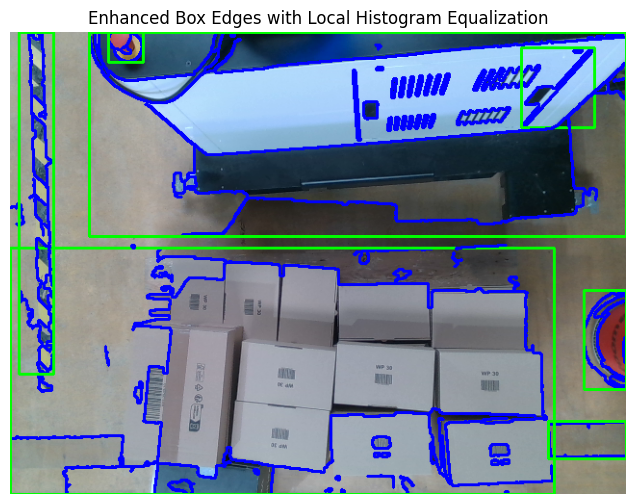

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('../data/small_box/color_image.png')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_gray = clahe.apply(gray)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(enhanced_gray, (5, 5), 0)

# Perform Canny Edge Detection with adjusted thresholds
edges = cv2.Canny(blurred, 50, 150)

# Refine edges using morphological operations (dilation followed by erosion)
kernel = np.ones((3, 3), np.uint8)
dilated = cv2.dilate(edges, kernel, iterations=1)
refined_edges = cv2.erode(dilated, kernel, iterations=1)

# Find contours from the refined edges
contours, _ = cv2.findContours(refined_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours and bounding boxes on a copy of the original image
image_with_contours = image.copy()
for contour in contours:
    # Draw the contour on the image
    cv2.drawContours(image_with_contours, [contour], -1, (255, 0, 0), 2)  # Blue contours

    # Get bounding box and filter small boxes
    x, y, w, h = cv2.boundingRect(contour)
    if w > 30 and h > 30:  # Adjust size filter for smaller boxes
        cv2.rectangle(image_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Green bounding box

# Convert BGR image to RGB for matplotlib
image_rgb = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

# Display the result using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title('Enhanced Box Edges with Local Histogram Equalization')
plt.axis('off')  # Hide axes for better visualization
plt.show()


### Experiment with thresholding of the 3D Image

In [4]:
import cv2 as cv
import numpy as np

depth_image *= 1000  # now in mm


cv.namedWindow("Depth Threshold")
cv.createTrackbar("Min", "Depth Threshold", 0, 400, lambda x: None)
cv.createTrackbar("Max", "Depth Threshold", 100, 400, lambda x: None)

while True:
    min_val = cv.getTrackbarPos("Min", "Depth Threshold")
    max_val = cv.getTrackbarPos("Max", "Depth Threshold")

    mask = ((depth_image > min_val) & (depth_image < max_val)).astype(np.uint8) * 255
    cv.imshow("Depth Threshold", mask.astype(np.uint8))

    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cv.destroyAllWindows()


In [ ]:
import open3d as o3d
import numpy as np

# Assuming you have intrinsics and depth_image (float32, in meters)
# Convert to Open3D depth image
depth_o3d = o3d.geometry.Image(depth_image)

# Camera intrinsics (replace with yours)
intrinsics = o3d.camera.PinholeCameraIntrinsic(
    width=depth_image.shape[1],
    height=depth_image.shape[0],
    fx=600, fy=600, cx=depth_image.shape[1]//2, cy=depth_image.shape[0]//2
)

# Create point cloud
pcd = o3d.geometry.PointCloud.create_from_depth_image(depth_o3d, intrinsics)

# Plane segmentation using RANSAC
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)

print("Plane model:", plane_model)

# Create inlier mask
inlier_cloud = pcd.select_by_index(inliers)
non_floor_cloud = pcd.select_by_index(inliers, invert=True)

# Visualize or export point cloud without floor
o3d.visualization.draw_geometries([non_floor_cloud])


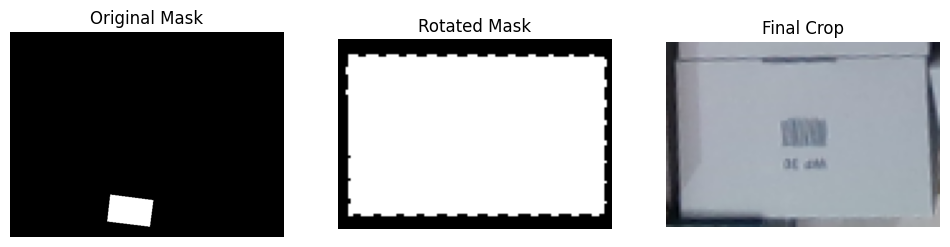

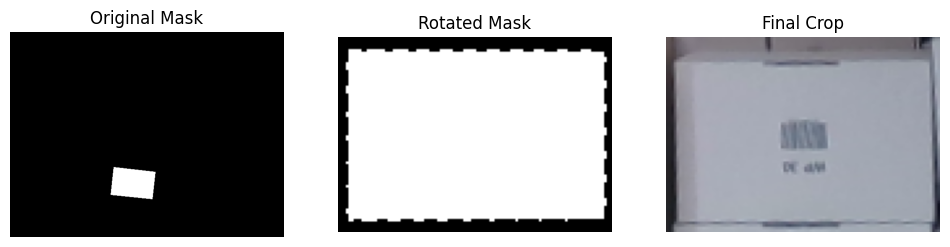

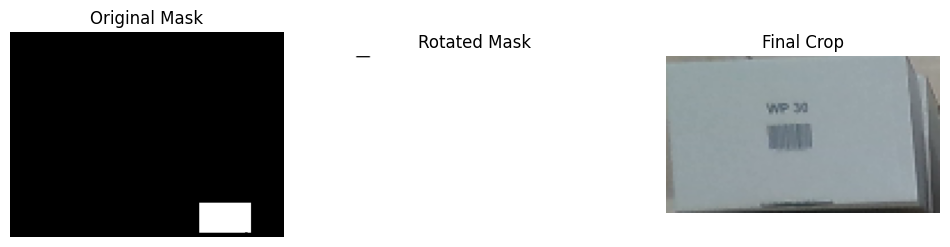

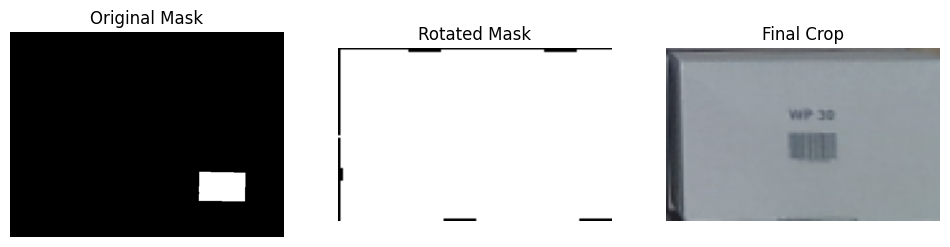

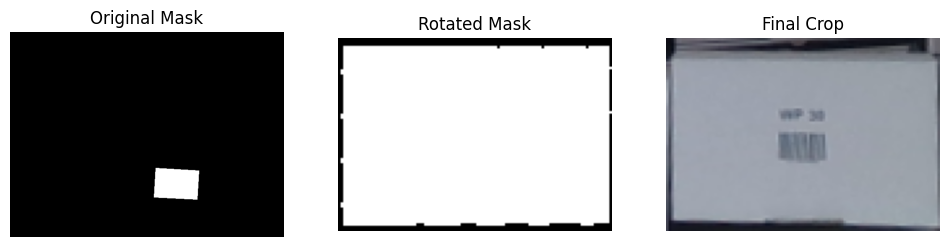

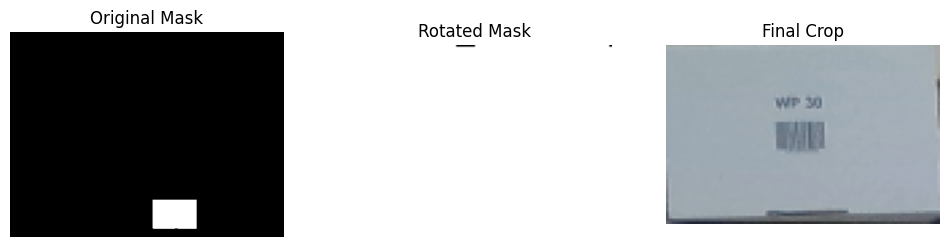

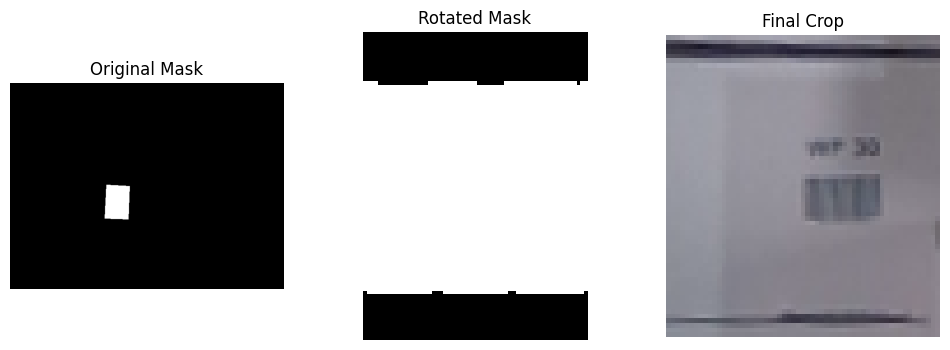

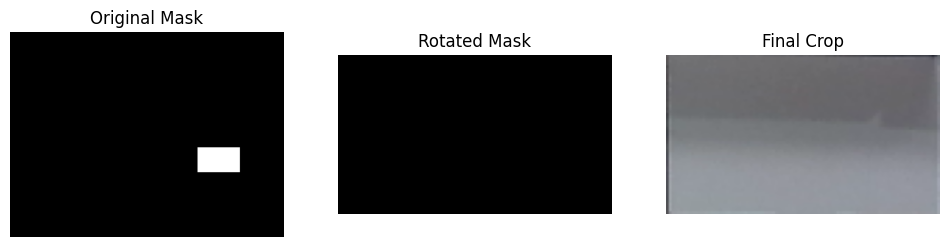

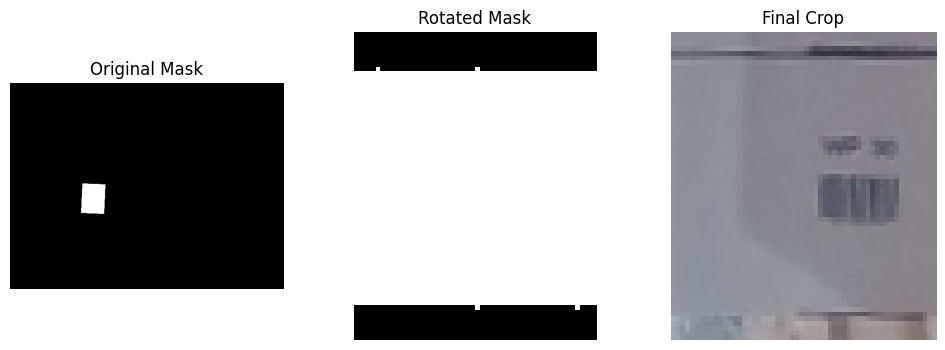

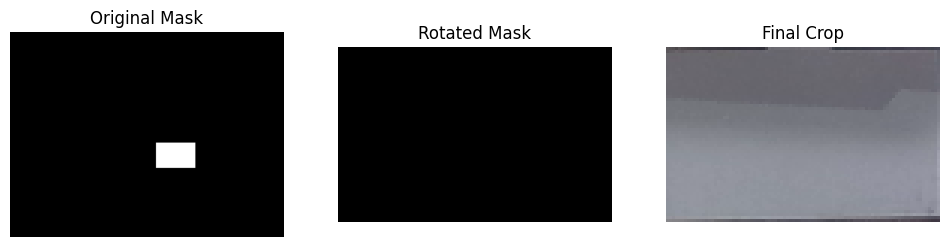

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the 2D image
image_2d = cv.imread('../data/small_box/color_image.png')

for i in range(1, 11):
    # Load mask and create binary image
    mask = cv.imread(f'../data/small_box/small_box_mask_{i}.png', cv.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Mask image {i} not found, skipping.")
        continue

    # Optional: Otsu's thresholding for robustness
    _, binary_mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Define a rectangular kernel for closing (adjust size as needed)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (5, 5))

    # Apply morphological closing to fill small holes
    mask = cv.morphologyEx(binary_mask, cv.MORPH_CLOSE, kernel)


    # Find contours and get largest one
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"No contours found in mask {i}, skipping.")
        continue

    max_contour = max(contours, key=cv.contourArea)

    # Get rotated rectangle and angle correction
    rotated_box = cv.minAreaRect(max_contour)
    (cx, cy), (w, h), angle = rotated_box

    # Adjust angle to ensure horizontal alignment
    if w < h:
        angle += 90
        w, h = h, w  # Swap dimensions

    # Get rotation matrix and calculate new size
    rot_mat = cv.getRotationMatrix2D((cx, cy), angle, 1)
    cos = np.abs(rot_mat[0, 0])
    sin = np.abs(rot_mat[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust rotation matrix center
    rot_mat[0, 2] += (new_w / 2) - cx
    rot_mat[1, 2] += (new_h / 2) - cy

    # Apply rotation to both mask and color image
    rotated_mask = cv.warpAffine(mask, rot_mat, (new_w, new_h), flags=cv.INTER_NEAREST)
    rotated_color = cv.warpAffine(image_2d, rot_mat, (new_w, new_h))

    # Find tight bounding box after rotation
    ys, xs = np.where(rotated_mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        print(f"No nonzero pixels in rotated mask {i}, skipping.")
        continue
    min_x, max_x = np.min(xs), np.max(xs)
    min_y, max_y = np.min(ys), np.max(ys)

    # Final crop with 5px padding
    pad = 5
    crop_y1 = max(0, min_y - pad)
    crop_y2 = min(rotated_color.shape[0], max_y + pad)
    crop_x1 = max(0, min_x - pad)
    crop_x2 = min(rotated_color.shape[1], max_x + pad)
    final_crop = rotated_color[crop_y1:crop_y2, crop_x1:crop_x2]

    # Save result
    cv.imwrite(f'../data/small_box/templates/image_{i}.png', final_crop)
    cv.imwrite(f'../data/small_box/templates/mask_{i}.png', rotated_mask)

    # Visualization (optional)
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(rotated_mask, cmap='gray')
    plt.title('Rotated Mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(cv.cvtColor(final_crop, cv.COLOR_BGR2RGB))
    plt.title('Final Crop')
    plt.axis('off')
    plt.show()
